In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution2D, LocallyConnected2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.preprocessing import image

In [3]:
model = Sequential()
model.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3)))
model.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2'))
model.add(Convolution2D(16, (9, 9), activation='relu', name='C3'))
model.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
model.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5') )
model.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
model.add(Flatten(name='F0'))
model.add(Dense(4096, activation='relu', name='F7'))
model.add(Dropout(rate=0.5, name='D0'))
model.add(Dense(8631, activation='softmax', name='F8'))

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (None, 142, 142, 32)      11648     
_________________________________________________________________
M2 (MaxPooling2D)            (None, 71, 71, 32)        0         
_________________________________________________________________
C3 (Conv2D)                  (None, 63, 63, 16)        41488     
_________________________________________________________________
L4 (LocallyConnected2D)      (None, 55, 55, 16)        62774800  
_________________________________________________________________
L5 (LocallyConnected2D)      (None, 25, 25, 16)        7850000   
_________________________________________________________________
L6 (LocallyConnected2D)      (None, 21, 21, 16)        2829456   
_________________________________________________________________
F0 (Flatten)                 (None, 7056)              0

In [5]:
deepface_model = Model(inputs=model.layers[0].input, outputs=model.layers[-3].output)

In [6]:
deepface_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1_input (InputLayer)        [(None, 152, 152, 3)]     0         
_________________________________________________________________
C1 (Conv2D)                  (None, 142, 142, 32)      11648     
_________________________________________________________________
M2 (MaxPooling2D)            (None, 71, 71, 32)        0         
_________________________________________________________________
C3 (Conv2D)                  (None, 63, 63, 16)        41488     
_________________________________________________________________
L4 (LocallyConnected2D)      (None, 55, 55, 16)        62774800  
_________________________________________________________________
L5 (LocallyConnected2D)      (None, 25, 25, 16)        7850000   
_________________________________________________________________
L6 (LocallyConnected2D)      (None, 21, 21, 16)        282945

In [7]:
opencv_home = cv2.__file__
folders = opencv_home.split(os.path.sep)[0:-1]
path = folders[0]
for folder in folders[1:]:
    path = path + "/" + folder

detector_path = path+"/data/haarcascade_frontalface_default.xml"

if os.path.isfile(detector_path) != True:
    raise ValueError("Confirm that opencv is installed on your environment! Expected path ",detector_path," violated.")
else:
    detector = cv2.CascadeClassifier(detector_path)
    print("haarcascade is oke")

haarcascade is oke


In [8]:
def detectFace(img_path, target_size=(152, 152)):
    
    img = cv2.imread(img_path)
    
    faces = detector.detectMultiScale(img, 1.3, 5)
    
    if len(faces) > 0:
        x,y,w,h = faces[0]
        
        margin = 0
        x_margin = w * margin / 100
        y_margin = h * margin / 100
        
        if y - y_margin > 0 and y+h+y_margin < img.shape[1] and x-x_margin > 0 and x+w+x_margin < img.shape[0]:
            detected_face = img[int(y-y_margin):int(y+h+y_margin), int(x-x_margin):int(x+w+x_margin)]
        else:
            detected_face = img[int(y):int(y+h), int(x):int(x+w)]
        
        detected_face = cv2.resize(detected_face, target_size)
        
        img_pixels = image.img_to_array(detected_face)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        
        #normalize in [0, 1]
        img_pixels /= 255 
        
        return img_pixels
    else:
        raise ValueError("Face could not be detected in ", img_path,". Please confirm that the picture is a face photo.")

In [9]:
def findCosineDistance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

def l2_normalize(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))

In [10]:
dataset = [
    [r'C:\Users\lenovo\Desktop\1.jpg', r'C:\Users\lenovo\Desktop\2.jpg', False]
    , [r'C:\Users\lenovo\Desktop\2.jpg', r'C:\Users\lenovo\Desktop\3.jpg', True]
    , [r'C:\Users\lenovo\Desktop\3.jpg' , r'C:\Users\lenovo\Desktop\4.jpg', False]
    , [r'C:\Users\lenovo\Desktop\4.jpg' , r'C:\Users\lenovo\Desktop\5.jpg', True]
    , [r'C:\Users\lenovo\Desktop\5.jpg', r'C:\Users\lenovo\Desktop\1.jpg', False]
    
]

C:\Users\lenovo\Desktop\1.jpg  and  C:\Users\lenovo\Desktop\2.jpg


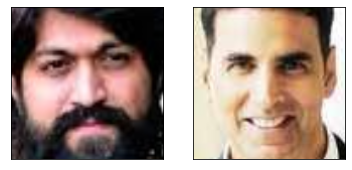

Cosine distance:  0.07924717664718628
Cosine L2 distance:  0.0792471170425415
Euclidean distance:  8.613303e-05
Euclidean L2 distance:  0.39811337
Actual:  False - Predicted:  False
----------------------------------------------
C:\Users\lenovo\Desktop\2.jpg  and  C:\Users\lenovo\Desktop\3.jpg


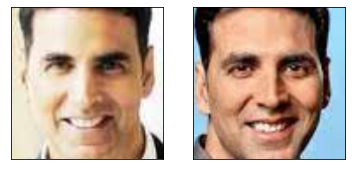

Cosine distance:  0.048227548599243164
Cosine L2 distance:  0.04822748899459839
Euclidean distance:  6.753065e-05
Euclidean L2 distance:  0.31057197
Actual:  True - Predicted:  True
----------------------------------------------
C:\Users\lenovo\Desktop\3.jpg  and  C:\Users\lenovo\Desktop\4.jpg


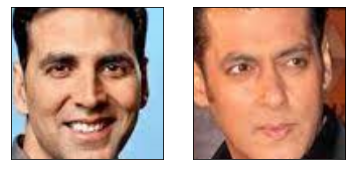

Cosine distance:  0.056409478187561035
Cosine L2 distance:  0.05640929937362671
Euclidean distance:  7.1126524e-05
Euclidean L2 distance:  0.335885
Actual:  False - Predicted:  False
----------------------------------------------
C:\Users\lenovo\Desktop\4.jpg  and  C:\Users\lenovo\Desktop\5.jpg


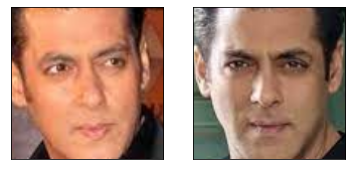

Cosine distance:  0.046514272689819336
Cosine L2 distance:  0.04651421308517456
Euclidean distance:  7.094695e-05
Euclidean L2 distance:  0.30500573
Actual:  True - Predicted:  True
----------------------------------------------
C:\Users\lenovo\Desktop\5.jpg  and  C:\Users\lenovo\Desktop\1.jpg


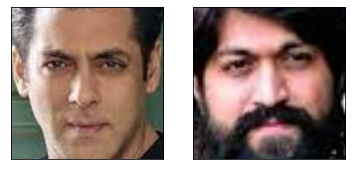

Cosine distance:  0.08131563663482666
Cosine L2 distance:  0.08131545782089233
Euclidean distance:  8.5355896e-05
Euclidean L2 distance:  0.40327534
Actual:  False - Predicted:  False
----------------------------------------------


In [12]:
for case in dataset:
    img1_path = case[0]
    img2_path = case[1]
    target = case[2]
    
    print(img1_path, " and ", img2_path)
    
    img1 = detectFace(img1_path)
    img2 = detectFace(img2_path)
    
    fig = plt.figure()
    fig.add_subplot(1,2, 1)
    plt.imshow(img1[0][:, :, ::-1])
    plt.xticks([]); plt.yticks([])
    fig.add_subplot(1,2, 2)
    plt.imshow(img2[0][:, :, ::-1])
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    
    #img1_embedding = model.predict(img1)[0] #this has 8631 dimensional output
    #img2_embedding = model.predict(img2)[0] #this has 8631 dimensional output
    img1_embedding = deepface_model.predict(img1)[0] #this has 4096 dimensional output
    img2_embedding = deepface_model.predict(img2)[0] #this has 4096 dimensional output
    
    cosine_distance = findCosineDistance(img1_embedding, img2_embedding)
    cosine_l2_distance = findCosineDistance(l2_normalize(img1_embedding), l2_normalize(img2_embedding))
    euclidean_distance = findEuclideanDistance(img1_embedding, img2_embedding)
    euclidean_l2_distance = findEuclideanDistance(l2_normalize(img1_embedding), l2_normalize(img2_embedding))
    
    print("Cosine distance: ", cosine_distance)
    print("Cosine L2 distance: ", cosine_l2_distance)
    print("Euclidean distance: ", euclidean_distance)
    print("Euclidean L2 distance: ", euclidean_l2_distance)
    print("Actual: ", target, end = '')
    
    #if cosine_distance < 0.16:
    if euclidean_l2_distance <= 0.32:
        verified = True
    else:
        verified = False
        
    print(" - Predicted: ", verified)
    
    print("----------------------------------------------")